<a href="https://colab.research.google.com/github/nghhuan05/ivp-ktlsp_groupassignment/blob/main/Spillover_Effect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# I. IMPORT LIBRARIES
from datetime import date
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import networkx as nx

# II. ĐỌC VÀ XỬ LÝ DATA
# 1. Đọc dữ liệu
df = pd.read_excel('VN30_preprocessed-2.xlsx')

# 2. Chuyển dữ liệu kiểu ngày
df['Date'] = pd.to_datetime(df['Date'])

# 3. Giữ lại các cột cần thiết
df = df[['Source.Name', 'Date','Price']]

# 4. Pivot sang dạng wide
price_df = df.pivot(index='Date', columns='Source.Name', values='Price').sort_index()

# 5. Sắp xếp theo ngày
price_df = price_df.sort_index()

# 6. Tính log return (để loại bỏ xu hướng)
returns = np.log(price_df/price_df.shift(1)).dropna()

print("Dữ liệu returns:")
print(returns.head())

Dữ liệu returns:
Source.Name   ACB.csv   BCM.csv   BID.csv   CTG.csv   DGC.csv   FPT.csv  \
Date                                                                      
2021-03-26   0.012403  0.021284 -0.003556 -0.008923 -0.005985 -0.006549   
2021-03-29   0.016807  0.008728  0.010631  0.024035  0.051021  0.019519   
2021-03-30   0.009050  0.005214  0.007028  0.009953 -0.028819 -0.006464   
2021-03-31   0.000000 -0.005214  0.002330 -0.006208 -0.013278  0.007751   
2021-04-01   0.016382 -0.001732  0.023015  0.022167  0.023442  0.025414   

Source.Name   GAS.csv   GVR.csv   HDB.csv   HPG.csv  ...   TCB.csv   TPB.csv  \
Date                                                 ...                       
2021-03-26  -0.012257 -0.010959  0.005842  0.026321  ...  0.001270 -0.007460   
2021-03-29   0.003357  0.019958  0.009662  0.002160  ...  0.003800  0.025879   
2021-03-30   0.001117  0.012493  0.007663  0.003232  ...  0.012563  0.014493   
2021-03-31   0.001114 -0.014301  0.007605  0.007510  ... 


 Thống kê mô tả:
              count      mean       std       min       25%       50%  \
Source.Name                                                             
ACB.csv      1139.0  0.000137  0.019652 -0.200664 -0.006715  0.000000   
BCM.csv      1139.0  0.000154  0.021772 -0.072451 -0.009527  0.000000   
BID.csv      1139.0  0.000079  0.020406 -0.139339 -0.008772  0.000000   
CTG.csv      1139.0  0.000420  0.020644 -0.117449 -0.009196  0.001095   
DGC.csv      1139.0  0.001140  0.026026 -0.072551 -0.011295  0.000000   
FPT.csv      1139.0  0.000880  0.017143 -0.072476 -0.007076  0.000000   
GAS.csv      1139.0 -0.000025  0.018611 -0.072467 -0.007887  0.000000   
GVR.csv      1139.0 -0.000020  0.028148 -0.072563 -0.012733  0.001544   
HDB.csv      1139.0  0.000561  0.021037 -0.195744 -0.008335  0.000000   
HPG.csv      1139.0  0.000269  0.021625 -0.072570 -0.009838  0.000000   
LPB.csv      1139.0  0.001503  0.024830 -0.091580 -0.010957  0.001644   
MBB.csv      1139.0  0.000847  0.

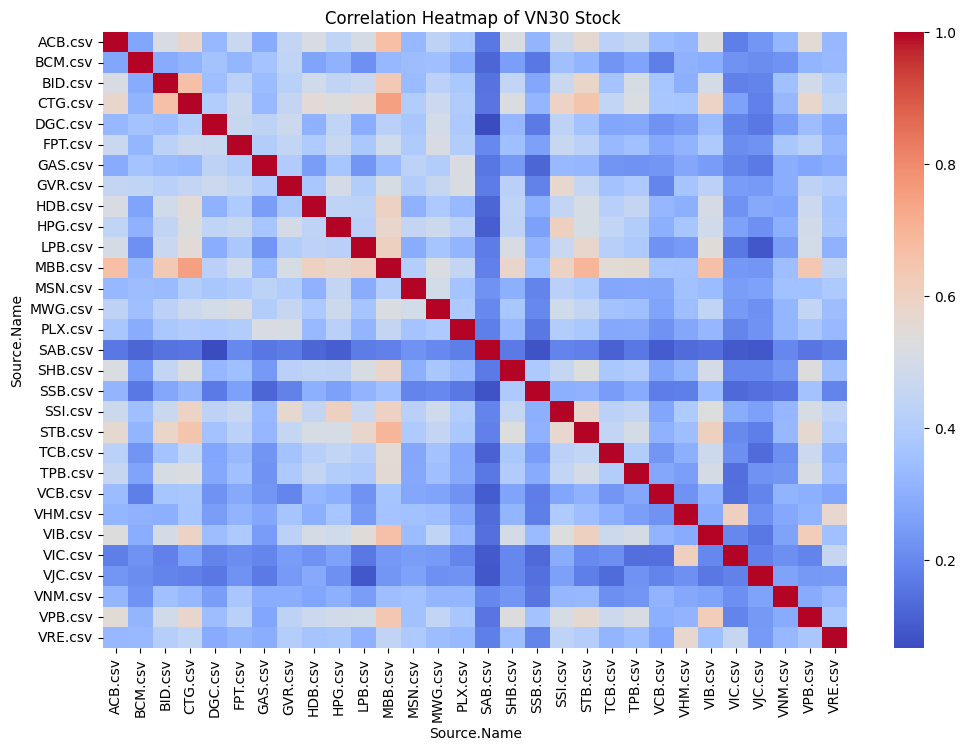

In [3]:
# III. Phân tích mô tả (EDA)
# 1. Thống kê
print("\n Thống kê mô tả:")
describe_df = returns.describe().T
print(describe_df)

# Save the describe DataFrame to an Excel file
describe_df.to_excel('describe_full.xlsx')

# 2. Heatmap tương quan
plt.figure(figsize=(12, 8))
sns.heatmap(returns.corr(), annot=False, cmap='coolwarm')
plt.title("Correlation Heatmap of VN30 Stock ")
plt.show()


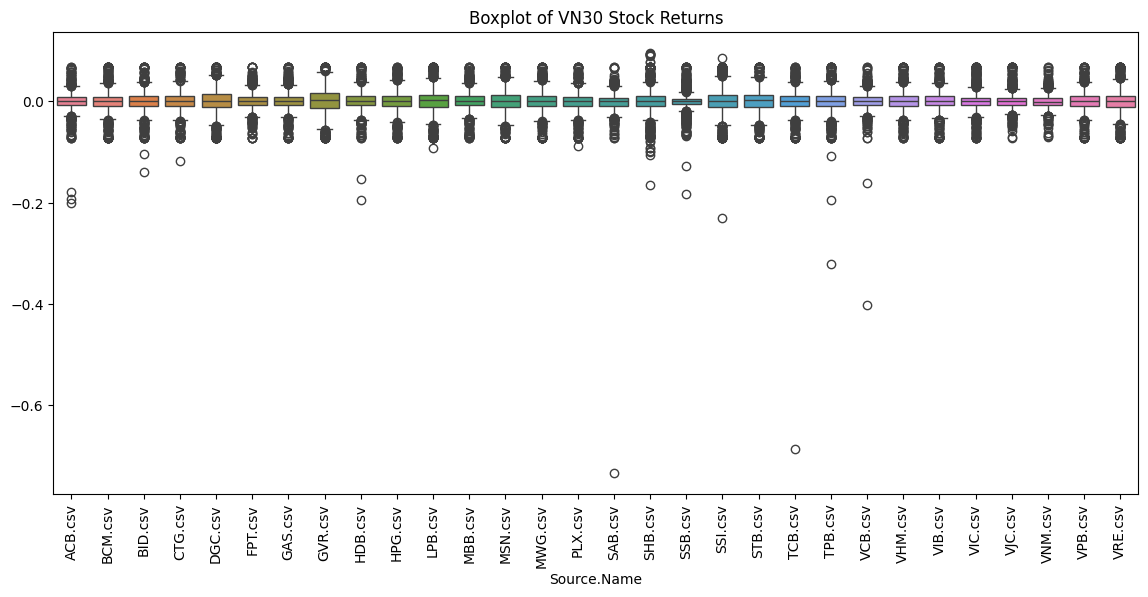

In [4]:
# 3. Boxplot biến động lợi suất
plt.figure(figsize=(14, 6))
sns.boxplot(data=returns)
plt.xticks(rotation=90)
plt.title("Boxplot of VN30 Stock Returns")
plt.show()


 Kết quả phân cụm cổ phiếu theo hành vi lợi suất:
      Stock  Cluster
0   ACB.csv        0
2   BID.csv        0
3   CTG.csv        0
8   HDB.csv        0
11  MBB.csv        0
10  LPB.csv        0
9   HPG.csv        0
16  SHB.csv        0
20  TCB.csv        0
28  VPB.csv        0
24  VIB.csv        0
21  TPB.csv        0
18  SSI.csv        0
19  STB.csv        0
22  VCB.csv        1
27  VNM.csv        1
26  VJC.csv        1
1   BCM.csv        2
13  MWG.csv        2
12  MSN.csv        2
4   DGC.csv        2
5   FPT.csv        2
6   GAS.csv        2
7   GVR.csv        2
14  PLX.csv        2
15  SAB.csv        3
23  VHM.csv        3
17  SSB.csv        3
25  VIC.csv        3
29  VRE.csv        3

 So sánh giữa phân cụm hành vi và phân nhóm ngành:
Sector   Other
Cluster       
0           14
1            3
2            8
3            5


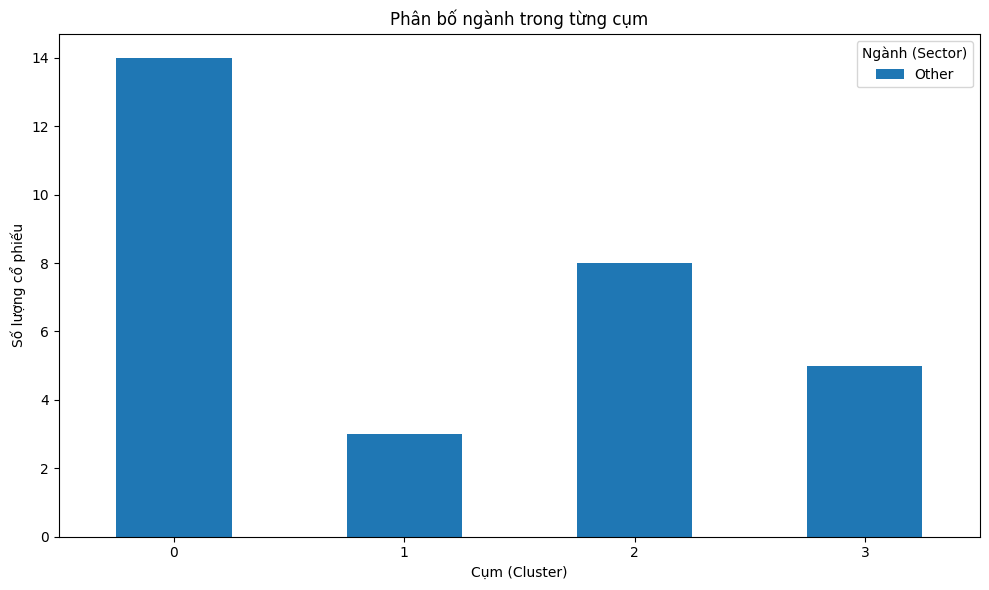

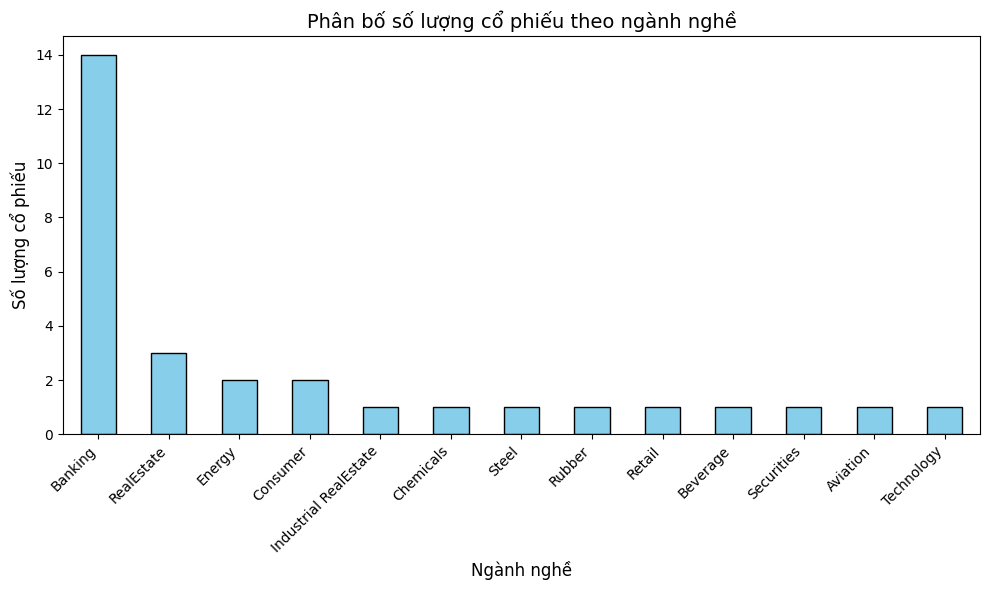

In [31]:
# IV. PHÂN CỤM, PHÂN NHÓM CỔ PHIẾU
# 1. PHÂN CỤM CỔ PHIẾU THEO HÀNH VI LỢI SUẤT

# Tính ma trận tương quan giữa các cổ phiếu
corr = returns.corr()

# Chuẩn hóa dữ liệu trước khi phân cụm
scaler = StandardScaler()
scaled_corr = scaler.fit_transform(corr)

# Áp dụng mô hình K-means để tìm cụm hành vi giá
kmeans = KMeans(n_clusters=4, random_state=42)
labels = kmeans.fit_predict(scaled_corr)

# Tạo bảng kết quả phân cụm
clusters = pd.DataFrame({
    'Stock': corr.columns,
    'Cluster': labels
})

print("\n Kết quả phân cụm cổ phiếu theo hành vi lợi suất:")
print(clusters.sort_values('Cluster'))

# 2. PHÂN NHÓM CỔ PHIẾU THEO NGÀNH NGHỀ (SECTOR)
sector_dict = {
    # Bank
    'ACB': 'Banking', 'BID': 'Banking', 'CTG': 'Banking', 'HDB': 'Banking', 'LPB': 'Banking',
    'MBB': 'Banking', 'SHB': 'Banking', 'SSB': 'Banking', 'STB': 'Banking', 'TCB': 'Banking',
    'VCB': 'Banking', 'TPB': 'Banking', 'VIB': 'Banking', 'VPB': 'Banking',

    # Bất động sản & Khu công nghiệp
    'VIC': 'RealEstate', 'VHM': 'RealEstate', 'VRE': 'RealEstate', 'BCM': 'Industrial RealEstate',

    # Sản xuất & Nguyên vật liệu
    'HPG': 'Steel', 'DGC': 'Chemicals', 'GVR': 'Rubber',

    # Năng lượng & Xăng dầu
    'GAS': 'Energy', 'PLX': 'Energy',

    # Bán lẻ & Hàng tiêu dùng
    'MWG': 'Retail', 'MSN': 'Consumer', 'SAB': 'Beverage', 'VNM': 'Consumer',

    # Tài chính & Chứng khoán
    'SSI': 'Securities',

    # Hàng không
    'VJC': 'Aviation',

    # Công nghệ
    'FPT': 'Technology'
}

# Gắn vào bảng phân cụm
clusters['Sector'] = clusters['Stock'].map(sector_dict).fillna('Other')

# 3. So sánh giữa phân cụm (Cluster) và phân nhóm ngành (Sector)
print("\n So sánh giữa phân cụm hành vi và phân nhóm ngành:")
comparison = clusters.groupby(['Cluster', 'Sector']).size().unstack(fill_value=0)
print(comparison)

# 4. Trực quan hóa kết quả phân nhóm
clusters['Cluster'] = clusters['Sector'].fillna('Other')
pivot = clusters.groupby(['Cluster', 'Sector']).size().unstack(fill_value=0)

# vẽ stacked bar (mỗi index = 1 Cluster)
comparison.plot(kind='bar', stacked=True, figsize=(10,6))

plt.title('Phân bố ngành trong từng cụm')
plt.xlabel('Cụm (Cluster)')
plt.ylabel('Số lượng cổ phiếu')
plt.legend(title='Ngành (Sector)')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Tạo DataFrame từ dict sector_dict
sector_df = pd.DataFrame(list(sector_dict.items()), columns=['Stock', 'Sector'])

# Đếm số lượng cổ phiếu trong từng ngành
sector_counts = sector_df['Sector'].value_counts().sort_values(ascending=False)

# Vẽ biểu đồ
plt.figure(figsize=(10,6))
sector_counts.plot(kind='bar', color='skyblue', edgecolor='black')

plt.title('Phân bố số lượng cổ phiếu theo ngành nghề', fontsize=14)
plt.xlabel('Ngành nghề', fontsize=12)
plt.ylabel('Số lượng cổ phiếu', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Phân tích nhóm ngành: Other
Các cổ phiếu được chọn: ['ACB.csv', 'BCM.csv', 'BID.csv', 'CTG.csv', 'DGC.csv']
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 28, Oct, 2025
Time:                     06:41:37
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   -39.6541
Nobs:                     1138.00    HQIC:                  -39.7367
Log likelihood:           14595.0    FPE:                5.25750e-18
AIC:                     -39.7869    Det(Omega_mle):     5.12106e-18
--------------------------------------------------------------------
Results for equation ACB.csv
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const              0.000086         0.000584            0.147           0.883
L1.ACB.csv        -0.034511         0.03

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


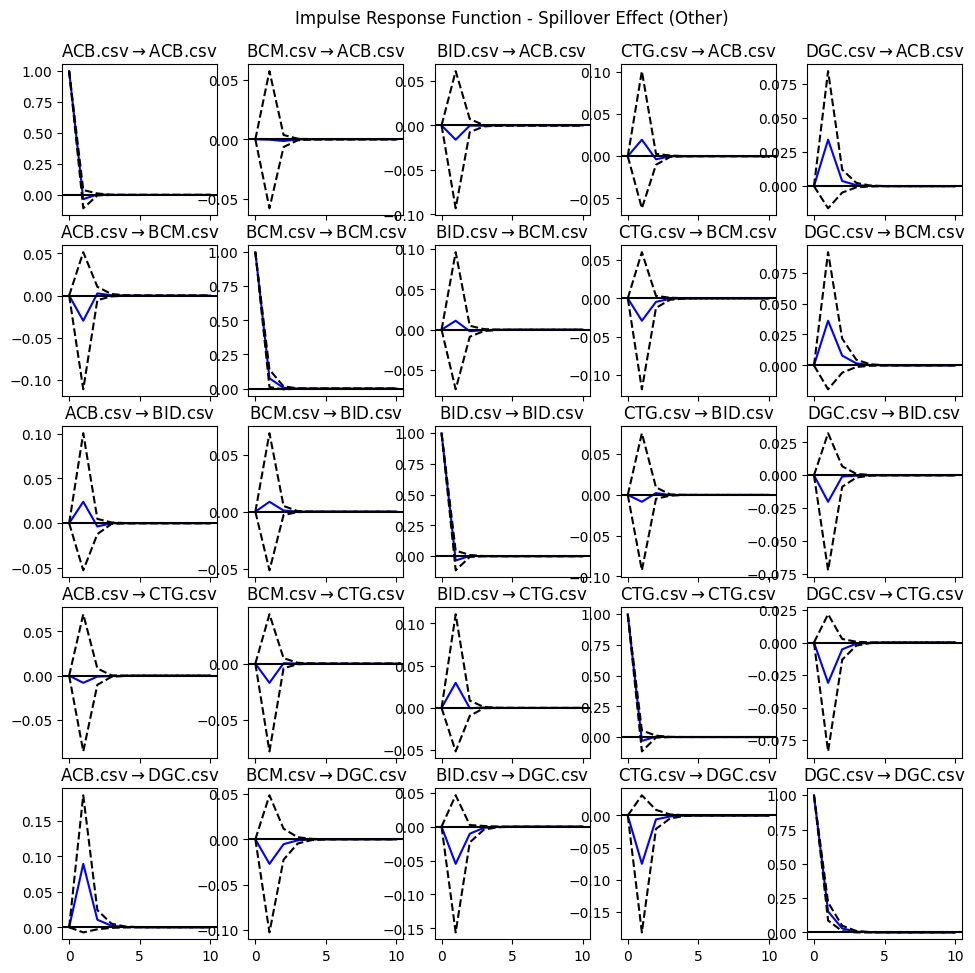

In [6]:
# V. PHÂN TÍCH SPILLOVER (VAR)

# Chọn 1 nhóm ngành cụ thể để phân tích
sector_counts = clusters['Sector'].value_counts()
main_sector = sector_counts.index[0]
print(f"Phân tích nhóm ngành: {main_sector}")

# Lọc danh sách cổ phiếu thuộc nhóm này
sector_stocks = clusters[clusters['Sector'] == main_sector]['Stock'].tolist()

# Chọn ngẫu nhiên 5 cổ phiếu đầu tiên
subset_cols = sector_stocks[:5] if len(sector_stocks) >= 5 else sector_stocks
print(f"Các cổ phiếu được chọn: {subset_cols}")

# Lấy dữ liệu return tương ứng
subset_returns = returns[subset_cols].dropna()

# Xây dựng mô hình VAR
model = VAR(subset_returns)
results = model.fit(maxlags=5, ic='aic')
print(results.summary())

# Phân tích Impulse Response Function (IRF)
irf = results.irf(10)
irf.plot(orth=False)
plt.suptitle(f'Impulse Response Function - Spillover Effect ({main_sector})')
plt.show()

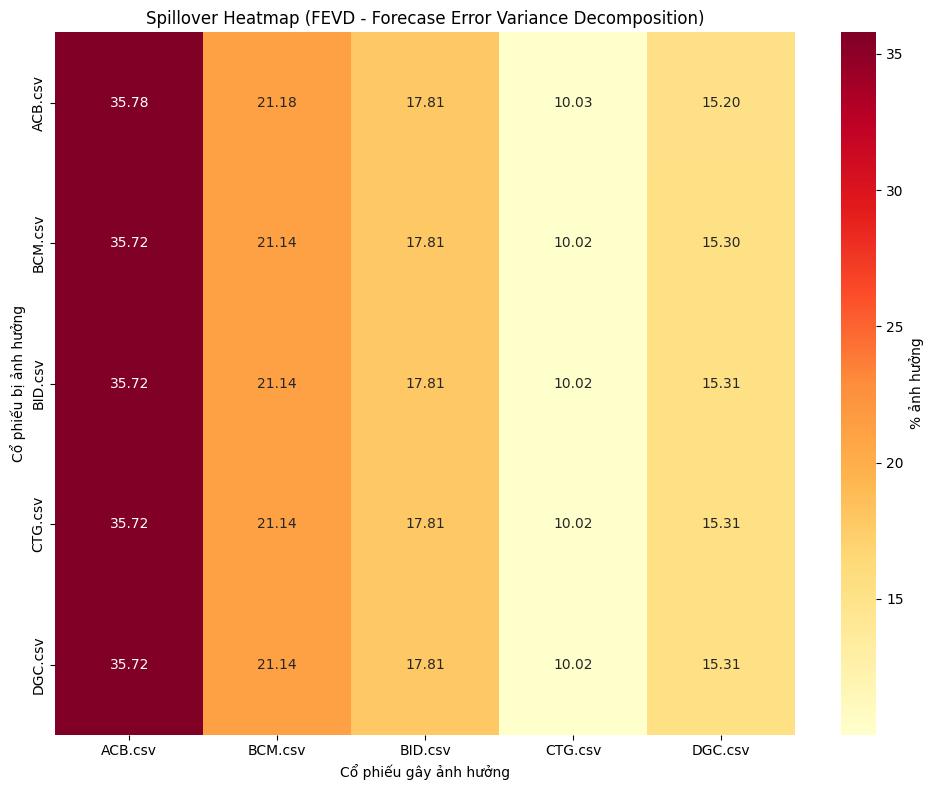

/tmp/ipython-input-2853563944.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


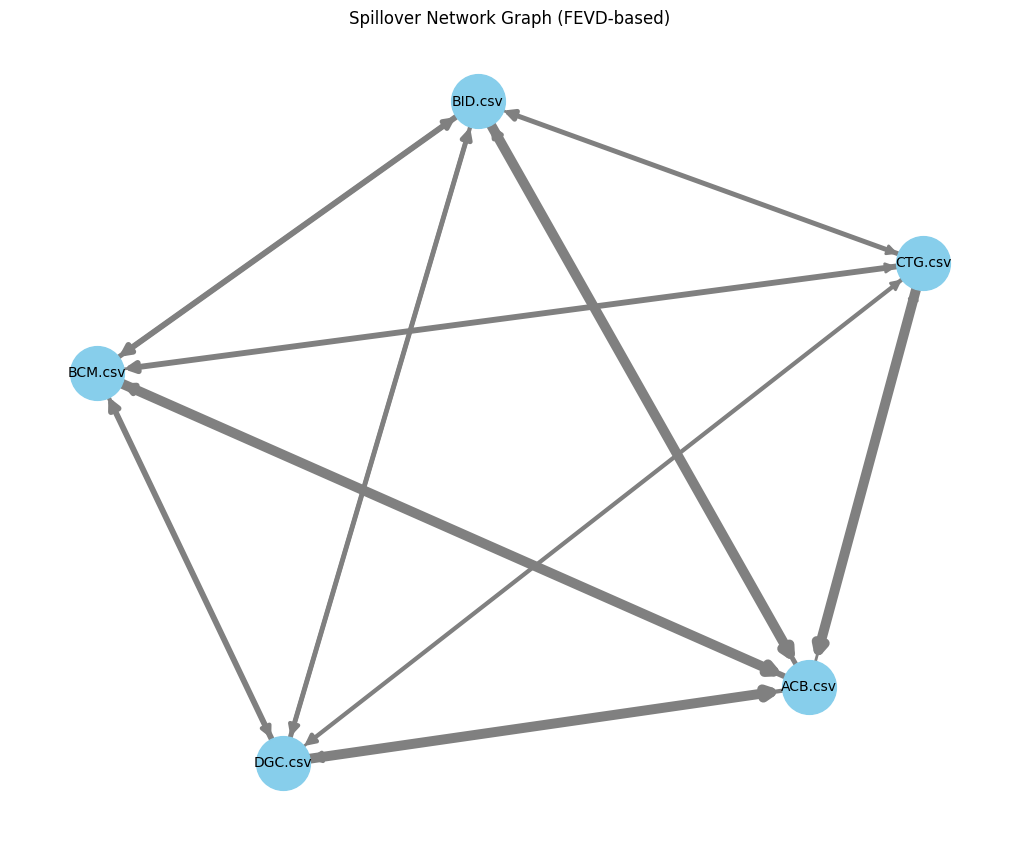

Total Spillover Index (Diebold-Yilmaz): 79.99%


In [7]:
# VI. Trực quan hóa kết quả

# 1. FEVD (Forecast Error Variance Decomposition)
fevd = results.fevd(5)
fevd_matrix = np.mean(fevd.decomp, axis=0)

# 2. Chuẩn hóa ma trận thành tỷ lệ phần trăm
spill_matrix = fevd_matrix / fevd_matrix.sum(axis=1, keepdims=True) * 100
spill_df = pd.DataFrame(spill_matrix, index=subset_cols, columns=subset_cols)

# 3. HEATMAP lan tỏa
plt.figure(figsize=(10,8))
sns.heatmap(spill_df, annot=True, fmt=".2f", cmap="YlOrRd", cbar_kws={'label': '% ảnh hưởng'})
plt.title("Spillover Heatmap (FEVD - Forecase Error Variance Decomposition)")
plt.xlabel("Cổ phiếu gây ảnh hưởng")
plt.ylabel("Cổ phiếu bị ảnh hưởng")
plt.tight_layout()
plt.show()

# 4. NETWORK GRAPH (Mối quan hệ lan tỏa có hướng)
G = nx.DiGraph()

# Thêm các cạnh có trọng số lan tỏa > 1%
for i in range(len(spill_df)):
  for j in range(len(spill_df)):
    if i != j and spill_df.iloc[i, j] >1:
      G.add_edge(spill_df.index[i], spill_df.columns[j],
                 weight=spill_df.iloc[i, j])

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, iterations=42)
edges = G.edges(data=True)

nx.draw(G, pos,
        with_labels=True,
        node_color='skyblue',
        node_size=1500,
        font_size=10,
        edge_color='gray',
        width=[d['weight']/5 for (u, v, d) in edges],
        arrowsize=15,
        arrowstyle='-|>')
plt.title("Spillover Network Graph (FEVD-based)")
plt.tight_layout()
plt.show()

# 5. Tính toán SPILLOVER INDEX (Chỉ số lan tỏa tổng thể - Diebold Yilmaz)
n = len(spill_df)
off_diag_sum = spill_df.values.sum() - np.trace(spill_df.values)
total_spillover = off_diag_sum / spill_df.values.sum() * 100

print(f"Total Spillover Index (Diebold-Yilmaz): {total_spillover:.2f}%")
